## Project 9 Part 2 - Airbnb Rent Price Prediction

### Notebook Content

1. Model training and evaluation.


In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score, train_test_split

import xgboost as xgb

from skopt import gp_minimize
from skopt.plots import (plot_convergence, plot_evaluations, plot_objective)
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
from skopt import BayesSearchCV

Import dataset

In [3]:
train = pd.read_csv('datasets/ds_train_v2.csv')
test = pd.read_csv('datasets/ds_test_v2.csv')

In [4]:
X_train = train.drop(columns='price')            
y_train = train['price']
X_test = test.drop(columns='price')            
y_test = test['price']

In [5]:
print('X_train shape: {}, type: {}'.format(X_train.shape, type(X_train)))
print('y_train shape: {}, type: {}'.format(y_train.shape,type(y_train)))
print('X_test shape: {}, type: {}'.format(X_test.shape,type(X_test)))
print('y_test shape: {}, type: {}'.format(y_test.shape,type(y_test)))

X_train shape: (24426, 23), type: <class 'pandas.core.frame.DataFrame'>
y_train shape: (24426,), type: <class 'pandas.core.series.Series'>
X_test shape: (6134, 23), type: <class 'pandas.core.frame.DataFrame'>
y_test shape: (6134,), type: <class 'pandas.core.series.Series'>


### Model XGBoost Regressor with Bayesian Optimization 

Hyperparameter Space definition:

In [19]:
param_grid = [
              Integer(50, 300, name='n_estimators'),  
              Integer(1, 10, name='max_depth'),
              Real(0.01, 0.99, name='learning_rate'),
              Categorical(['gbtree', 'dart'], name='booster'),
              Real(0.01, 10, name='gamma'),
              Real(0.50, 0.90, name='subsample'),
              Real(0.50, 0.90, name='colsample_bytree'),
              Real(0.50, 0.90, name='colsample_bylevel'),
              Real(0.50, 0.90, name='colsample_bynode'),
              Integer(1, 50, name='reg_lambda'),
              ]

Model definition:

In [20]:
gbm = xgb.XGBRegressor(random_state=42)

Objective function definition:

In [21]:
@use_named_args(param_grid)
def objective(**params):
    
    gbm.set_params(**params)

    value = np.mean(cross_val_score(
                                    gbm, 
                                    X_train,
                                    y_train,
                                    cv=3,
                                    n_jobs=-1,
                                    )
                    )
    
    return -value 

### Bayesian Optimization

In [22]:
gp_ = gp_minimize(
                  objective, 
                  param_grid, 
                  n_initial_points=5, 
                  acq_func='EI', 
                  n_calls=20, 
                  random_state=42
                  )

In [23]:
"Best score=%.4f" % gp_.fun

'Best score=-0.6393'

In [24]:
gp_.x

[277,
 4,
 0.3418580157284763,
 'gbtree',
 5.388417648179694,
 0.6486866702908727,
 0.5817127143373557,
 0.761454126680555,
 0.5696624120752922,
 45]

In [25]:
print("""Best parameters:
=========================
- n_estimators = %d
- max_depth = %d
- learning_rate = %.6f
- booster = %s
- gamma = %.6f
= subsample = %.6f
- colsample_bytree = %.6f
- colsample_bylevel = %.6f
- colsample_bynode' = %.6f
""" % (gp_.x[0],
       gp_.x[1],
       gp_.x[2],
       gp_.x[3],
       gp_.x[4],
       gp_.x[5],
       gp_.x[6],
       gp_.x[7],
       gp_.x[8],
      ))

Best parameters:
- n_estimators = 277
- max_depth = 4
- learning_rate = 0.341858
- booster = gbtree
- gamma = 5.388418
= subsample = 0.648687
- colsample_bytree = 0.581713
- colsample_bylevel = 0.761454
- colsample_bynode' = 0.569662



Convergence Evaluation:

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

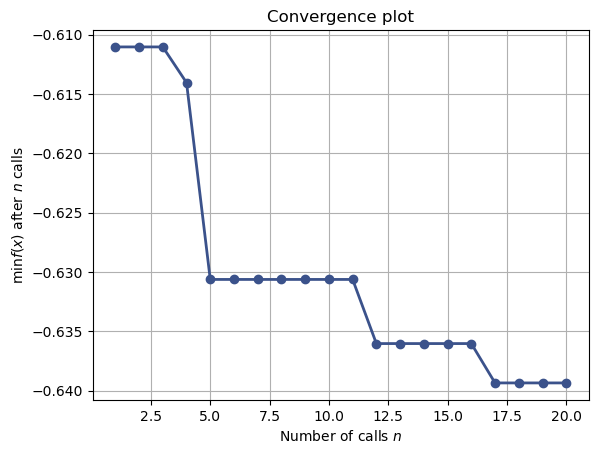

In [26]:
plot_convergence(gp_)

The search found the best parameters after 17 iterations.